[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/042_cnns/cnns.ipynb)

# Redes Neuronales Convolucionales

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

In [38]:
device

'cuda'

In [39]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/2-SIS421/kaggle'

In [41]:
# Reemplaza 'dataset-name' con el nombre del conjunto de datos en la URL
!kaggle datasets download -d juniorbueno/rating-opencv-emotion-images

rating-opencv-emotion-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [42]:
import zipfile

with zipfile.ZipFile('/content/rating-opencv-emotion-images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [43]:
import os
PATH = 'Images/train'
classes = os.listdir(PATH)
classes
print(classes)

['Happy', 'Angry', 'Disgust', 'Neutral', 'Sad', 'Surprise', 'Fear']


In [44]:
trainimgs, trainlabels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  trainimgs += [f'{PATH}/{lab}/{img}' for img in paths]
  trainlabels += [i]*len(paths)

Categoría: Happy. Imágenes: 7215
Categoría: Angry. Imágenes: 3995
Categoría: Disgust. Imágenes: 436
Categoría: Neutral. Imágenes: 4965
Categoría: Sad. Imágenes: 4830
Categoría: Surprise. Imágenes: 3171
Categoría: Fear. Imágenes: 4097


In [45]:
PATH2 = 'Images/validation'
classes2 = os.listdir(PATH)
classes2
print(classes2)

['Happy', 'Angry', 'Disgust', 'Neutral', 'Sad', 'Surprise', 'Fear']


In [46]:
testimgs, testlabels = [], []

for i, lab in enumerate(classes2):
  paths = os.listdir(f'{PATH2}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  testimgs += [f'{PATH}/{lab}/{img}' for img in paths]
  testlabels += [i]*len(paths)

Categoría: Happy. Imágenes: 879
Categoría: Angry. Imágenes: 491
Categoría: Disgust. Imágenes: 55
Categoría: Neutral. Imágenes: 626
Categoría: Sad. Imágenes: 594
Categoría: Surprise. Imágenes: 416
Categoría: Fear. Imágenes: 528


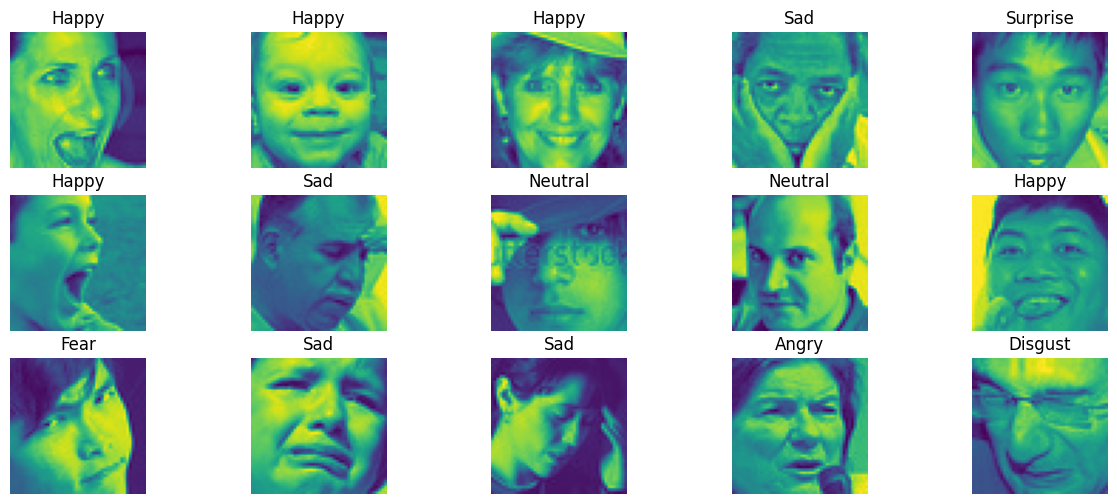

In [47]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(15,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(trainimgs)-1)
    img = io.imread(trainimgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[trainlabels[ix]])
plt.show()

In [48]:
import numpy as np
trainimgs_array = np.array(trainimgs)
trainlabels_array = np.array(trainlabels)
testimgs_array = np.array(testimgs)
testlabels_array = np.array(testlabels)
print(trainimgs_array.shape)

(28709,)


In [49]:
import torch
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # Convertir la imagen a formato RGB
    rgb_img = Image.fromarray(img).convert("RGB")
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=np.array(rgb_img))["image"]
      #img = self.trans(image=img)["image"]
    #return torch.from_numpy(img / 255.).float().unsqueeze(0), torch.tensor(self.y[ix])
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [50]:
import albumentations as A

trans = A.Compose([
    A.Resize(48, 48),
])

dataset = {
    'train': Dataset(trainimgs, trainlabels, trans, device),
    'test': Dataset(testimgs, testlabels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(28709, 3589)

In [51]:
#dataset['train'][5]

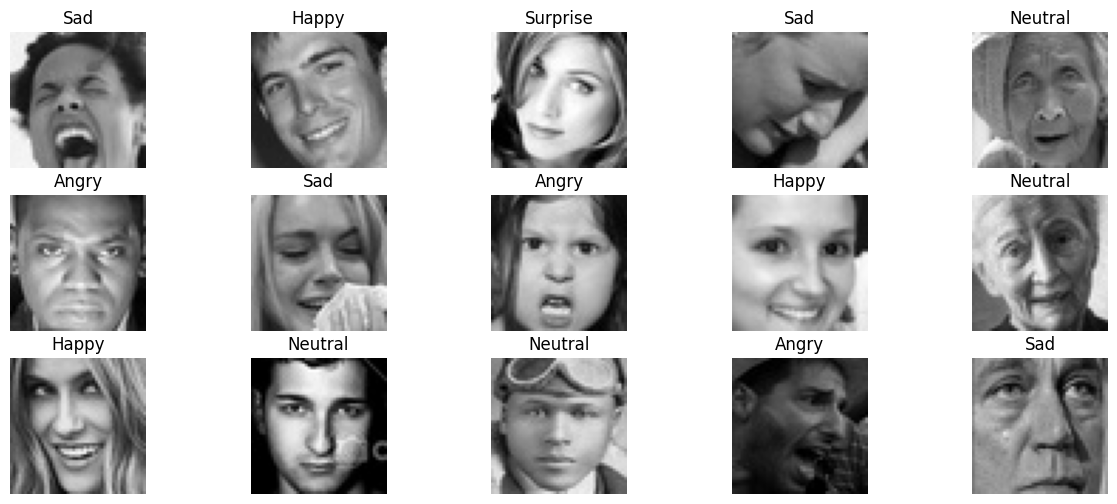

In [52]:
fig, axs = plt.subplots(3,5, figsize=(15,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    #print(img.shape)
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [53]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 48, 48])

## Redes Convolucionales

Una vez hemos visto los comoponentes principales de las `redes convolucionales` vamos a ver un ejemplo de cómo podemos implementar una red convolucional completa para, en este caso, la clasificación de las imágenes en el dataset MNIST. En primer lugar descargamos el dataset.

In [54]:
import torchvision

net = torchvision.models.squeezenet1_0()
net

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [55]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=7, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    net = torchvision.models.squeezenet1_0(pretrained=pretrained)
    #modificar la primera capa para un canal
    #net.features[0] = nn.Conv2d(1, 96, kernel_size=3, stride=2)
    # nos quedamos con todas las capas menos la última
    self.net = torch.nn.Sequential(*list(net.children())[:-1])
    if freeze:
      for param in self.net.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512*2*2, 7)

  def forward(self, x):
    x = self.net(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.net.parameters():
        param.requires_grad=True

In [56]:
model = ModelCustom()

output = model(torch.randn(64, 3, 48, 48))
print(output.shape)

torch.Size([64, 7])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Ahora, podemos entrenar la red utilizando nuestro bucle de entrenamiento.

In [57]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

Entrenando desde cero
En primer lugar vamos a entrenar nuestro modelo desde cero para ver qué métricas podemos obtener.

In [58]:
model_c = ModelCustom()
fit(model_c, dataloader, epochs=15)

val_loss 1.79699 val_acc 0.27292: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]


Epoch 1/15 loss 1.81113 val_loss 1.79699 acc 0.25189 val_acc 0.27292


val_loss 1.70497 val_acc 0.35911: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s]


Epoch 2/15 loss 1.73335 val_loss 1.70497 acc 0.30172 val_acc 0.35911


val_loss 1.65610 val_acc 0.33151: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


Epoch 3/15 loss 1.66074 val_loss 1.65610 acc 0.34511 val_acc 0.33151


val_loss 1.57051 val_acc 0.38833: 100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


Epoch 4/15 loss 1.58664 val_loss 1.57051 acc 0.37791 val_acc 0.38833


val_loss 1.54286 val_acc 0.40318: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]


Epoch 5/15 loss 1.54088 val_loss 1.54286 acc 0.40139 val_acc 0.40318


val_loss 1.56672 val_acc 0.38151: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]


Epoch 6/15 loss 1.50577 val_loss 1.56672 acc 0.41453 val_acc 0.38151


val_loss 1.48302 val_acc 0.40911: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]


Epoch 7/15 loss 1.47693 val_loss 1.48302 acc 0.42399 val_acc 0.40911


val_loss 1.45469 val_acc 0.40885: 100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


Epoch 8/15 loss 1.44576 val_loss 1.45469 acc 0.44170 val_acc 0.40885


val_loss 1.48941 val_acc 0.41990: 100%|██████████| 15/15 [00:03<00:00,  4.83it/s]


Epoch 9/15 loss 1.41873 val_loss 1.48941 acc 0.45116 val_acc 0.41990


val_loss 1.40038 val_acc 0.46078: 100%|██████████| 15/15 [00:02<00:00,  5.95it/s]


Epoch 10/15 loss 1.39613 val_loss 1.40038 acc 0.46067 val_acc 0.46078


val_loss 1.45634 val_acc 0.43234: 100%|██████████| 15/15 [00:02<00:00,  5.94it/s]


Epoch 11/15 loss 1.37700 val_loss 1.45634 acc 0.46951 val_acc 0.43234


val_loss 1.42661 val_acc 0.43854: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s]


Epoch 12/15 loss 1.34838 val_loss 1.42661 acc 0.48641 val_acc 0.43854


val_loss 1.36940 val_acc 0.46406: 100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch 13/15 loss 1.32633 val_loss 1.36940 acc 0.49416 val_acc 0.46406


val_loss 1.33226 val_acc 0.47687: 100%|██████████| 15/15 [00:03<00:00,  4.97it/s]


Epoch 14/15 loss 1.31147 val_loss 1.33226 acc 0.50015 val_acc 0.47687


val_loss 1.38593 val_acc 0.46151: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s]

Epoch 15/15 loss 1.28907 val_loss 1.38593 acc 0.50808 val_acc 0.46151


PRIMER PUNTO

-al hacer el entrenamiento desde cero con imagenes de 48x48 con 15 epochs se obtiene una precision de 53% y 51% en las de prueba
al hacer los cambios al la imagenes a 40x40 y un entrenamiento de 15 epochs se obtiene una precision de 51% y 48% en las practicas, segun estos resultados la presision varia segun la dimension de la imagen (negativamente) , esto se da por que al redudir(achatar, comprimir) es posible que se pierda infomacion o caracteristicas detallada o fina  de la imagen.

-al cambiar la imagenes a monocromatico obtube una precision de 56% y 47 con los de prueba, segun este resultado se ve la presision subio  un 3 % pero en las de prueba bajo un 4 % , por tanto varia (positivamente) , pero esto podria variar segun las tareas de clasificacion que quieras realizar ,
dato=  el data set en si es  a escalas de grises , y para hacer esta prueba yo converti las imagenes a rgb , y puede que la precision sea mejor  por que las imagenes originales son monocromaticas (mi punto de vista )




Transfer Learning

Ahora vamos a entrenar el mismo caso pero, en este caso, utilizando los pesos pre-entrenados de squeezenet1_0.

In [59]:
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader, epochs=10)

val_loss 101.09781 val_acc 0.29766: 100%|██████████| 15/15 [00:03<00:00,  4.94it/s]


Epoch 1/10 loss 161.44202 val_loss 101.09781 acc 0.28423 val_acc 0.29766


val_loss 123.25737 val_acc 0.32010: 100%|██████████| 15/15 [00:02<00:00,  5.20it/s]


Epoch 2/10 loss 138.94481 val_loss 123.25737 acc 0.31079 val_acc 0.32010


val_loss 148.41338 val_acc 0.30521: 100%|██████████| 15/15 [00:02<00:00,  6.10it/s]


Epoch 3/10 loss 133.37410 val_loss 148.41338 acc 0.31667 val_acc 0.30521


val_loss 75.68601 val_acc 0.37396: 100%|██████████| 15/15 [00:02<00:00,  6.10it/s]


Epoch 4/10 loss 134.00689 val_loss 75.68601 acc 0.32377 val_acc 0.37396


val_loss 148.10486 val_acc 0.27286: 100%|██████████| 15/15 [00:02<00:00,  5.87it/s]


Epoch 5/10 loss 128.87449 val_loss 148.10486 acc 0.33049 val_acc 0.27286


val_loss 149.70445 val_acc 0.30484: 100%|██████████| 15/15 [00:02<00:00,  5.76it/s]


Epoch 6/10 loss 127.46086 val_loss 149.70445 acc 0.33117 val_acc 0.30484


val_loss 84.04845 val_acc 0.33286: 100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


Epoch 7/10 loss 121.30283 val_loss 84.04845 acc 0.34108 val_acc 0.33286


val_loss 127.01710 val_acc 0.27813: 100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch 8/10 loss 121.84167 val_loss 127.01710 acc 0.33437 val_acc 0.27813


val_loss 163.03130 val_acc 0.29375: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]


Epoch 9/10 loss 124.58188 val_loss 163.03130 acc 0.33790 val_acc 0.29375


val_loss 113.47444 val_acc 0.25286: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s]

Epoch 10/10 loss 120.26963 val_loss 113.47444 acc 0.34263 val_acc 0.25286


Fine Tuning
Todavía podemos mejorar un poco más si, además de utilizar los pesos descargados de Imagenet en squeezenet1_0., entrenamos también la red completa.

In [60]:
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, dataloader , epochs= 10)

val_loss 1.77196 val_acc 0.28521: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]


Epoch 1/10 loss 1.86765 val_loss 1.77196 acc 0.28623 val_acc 0.28521


val_loss 1.50032 val_acc 0.42479: 100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


Epoch 2/10 loss 1.54529 val_loss 1.50032 acc 0.39582 val_acc 0.42479


val_loss 1.45993 val_acc 0.41224: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]


Epoch 3/10 loss 1.41308 val_loss 1.45993 acc 0.45450 val_acc 0.41224


val_loss 1.38977 val_acc 0.44609: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s]


Epoch 4/10 loss 1.32735 val_loss 1.38977 acc 0.49101 val_acc 0.44609


val_loss 1.33348 val_acc 0.47786: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]


Epoch 5/10 loss 1.27236 val_loss 1.33348 acc 0.51239 val_acc 0.47786


val_loss 1.30821 val_acc 0.48438: 100%|██████████| 15/15 [00:02<00:00,  5.97it/s]


Epoch 6/10 loss 1.23338 val_loss 1.30821 acc 0.52601 val_acc 0.48438


val_loss 1.28792 val_acc 0.49844: 100%|██████████| 15/15 [00:02<00:00,  5.76it/s]


Epoch 7/10 loss 1.19554 val_loss 1.28792 acc 0.54121 val_acc 0.49844


val_loss 1.18439 val_acc 0.53104: 100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


Epoch 8/10 loss 1.16008 val_loss 1.18439 acc 0.56016 val_acc 0.53104


val_loss 1.24761 val_acc 0.52193: 100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


Epoch 9/10 loss 1.12882 val_loss 1.24761 acc 0.56725 val_acc 0.52193


val_loss 1.14031 val_acc 0.54427: 100%|██████████| 15/15 [00:02<00:00,  6.10it/s]

Epoch 10/10 loss 1.10313 val_loss 1.14031 acc 0.57988 val_acc 0.54427


In [61]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader)
model_o.unfreeze()
fit(model_o, dataloader, lr=1e-4)

val_loss 67.48858 val_acc 0.34505: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]


Epoch 1/5 loss 167.70817 val_loss 67.48858 acc 0.27961 val_acc 0.34505


val_loss 111.36522 val_acc 0.22812: 100%|██████████| 15/15 [00:03<00:00,  4.76it/s]


Epoch 2/5 loss 141.86989 val_loss 111.36522 acc 0.30880 val_acc 0.22812


val_loss 108.55155 val_acc 0.28021: 100%|██████████| 15/15 [00:02<00:00,  5.25it/s]


Epoch 3/5 loss 132.45980 val_loss 108.55155 acc 0.32100 val_acc 0.28021


val_loss 104.26299 val_acc 0.34354: 100%|██████████| 15/15 [00:02<00:00,  6.12it/s]


Epoch 4/5 loss 127.98873 val_loss 104.26299 acc 0.32646 val_acc 0.34354


val_loss 120.94138 val_acc 0.33073: 100%|██████████| 15/15 [00:02<00:00,  5.96it/s]


Epoch 5/5 loss 129.30667 val_loss 120.94138 acc 0.33122 val_acc 0.33073


val_loss 1.91071 val_acc 0.24063: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]


Epoch 1/5 loss 3.37853 val_loss 1.91071 acc 0.22060 val_acc 0.24063


val_loss 1.79391 val_acc 0.27344: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


Epoch 2/5 loss 1.82815 val_loss 1.79391 acc 0.27438 val_acc 0.27344


val_loss 1.74681 val_acc 0.29615: 100%|██████████| 15/15 [00:02<00:00,  5.24it/s]


Epoch 3/5 loss 1.75508 val_loss 1.74681 acc 0.30050 val_acc 0.29615


val_loss 1.72456 val_acc 0.32089: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s]


Epoch 4/5 loss 1.71352 val_loss 1.72456 acc 0.32154 val_acc 0.32089


val_loss 1.69999 val_acc 0.32427: 100%|██████████| 15/15 [00:02<00:00,  5.92it/s]

Epoch 5/5 loss 1.68251 val_loss 1.69999 acc 0.33993 val_acc 0.32427


Eleji un data set de el cual es de 28709 imagenes de entrenamiento y 3589 de validacion o prueba  estas imagenes son de 48x48,
eleji el modelo pre entrenado squeezenet1_0 que se destaca por su tamaño reducido y eficiencia, lo que lo hace adecuado para aplicaciones con restricciones computacionales. A pesar de su tamaño compacto, logra mantener un buen rendimiento en tareas de clasificación.


## Resumen

En este post hemos introducido la arquitectura de `red neuronal` conocida como `red neuronal convolucional`. Este tipo de redes, inspiradas en el funcionamiento del córtex visual, están especialmente diseñadas para trabajar con imágenes. Gracias a la aplicación de la `capa convolucional`, la red será capaz de reconocer diferentes formas, colores y texturas que, de manera jerárquica, irá componiendo en estructuras cada vez más complejas para poder llevar a cabo su tarea de la mejor forma posible. En futuros posts hablaremos sobre diferente arquitecturas de CNN que han aparecido durante los últimos años y que podemos utilizar para nuestras aplicaciones.